# CYBERML - Project

#### Importation du dataset

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
# file1_path = "../SWaT.A7_June 2020/22June2020 (1).xlsx"
# file2_path = "../SWaT.A7_June 2020/22June2020 (2).xlsx"

# df1 = pd.read_excel(file1_path)
# df2 = pd.read_excel(file2_path)

In [ ]:
# if list(df1.columns) != list(df2.columns):
#     print("Les colonnes des deux fichiers ne correspondent pas.")
#     print("Colonnes dans le fichier 1 :", df1.columns)
#     print("Colonnes dans le fichier 2 :", df2.columns)
# else:
#     print("Les colonnes des deux fichiers correspondent.")
#     df_combined = pd.concat([df1, df2], axis=0, ignore_index=True)

#     # Vérifier le nombre de lignes et de colonnes du dataset combiné
#     print(f"Dataset combiné : {df_combined.shape} lignes et colonnes")

#     # Sauvegarder le dataset combiné dans un fichier CSV
#     output_path = "../SWaT.A7_June 2020/22June2020_combined.csv"
#     df_combined.to_csv(output_path, index=False)

#     print(f"Dataset fusionné sauvegardé dans : {output_path}")

Les colonnes des deux fichiers correspondent.
Dataset combiné : (18000, 82) lignes et colonnes
Dataset fusionné sauvegardé dans : ../SWaT.A7_June 2020/22June2020_combined.csv


In [9]:
df = pd.read_csv("../SWaT.A7_June 2020/22June2020_combined.csv")

In [10]:
df.head()

,t_stamp,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,...,FIT601.Pv,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm
0,2020-06-22 10:00:00.000,3,695.284100,0.0,1,1,1,2,0.000256,18.072288,...,0.000256,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active
1,2020-06-22 10:00:01.000,3,695.127100,0.0,1,1,1,2,0.000256,18.104332,...,0.000256,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active
2,2020-06-22 10:00:02.005,3,694.930847,0.0,1,1,1,2,0.000256,18.104332,...,0.000256,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active
3,2020-06-22 10:00:03.010,3,694.930847,0.0,1,1,1,2,0.000256,18.104332,...,0.000256,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active
4,2020-06-22 10:00:04.015,3,694.852300,0.0,1,1,1,2,0.000256,18.104332,...,0.000256,1,1,1,Inactive,Inactive,Active,Inactive,Inactive,Active


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   t_stamp        18000 non-null  object 
 1   P1_STATE       18000 non-null  int64  
 2   LIT101.Pv      18000 non-null  float64
 3   FIT101.Pv      18000 non-null  float64
 4   MV101.Status   18000 non-null  int64  
 5   P101.Status    18000 non-null  int64  
 6   P102.Status    18000 non-null  int64  
 7   P2_STATE       18000 non-null  int64  
 8   FIT201.Pv      18000 non-null  float64
 9   AIT201.Pv      18000 non-null  float64
 10  AIT202.Pv      18000 non-null  float64
 11  AIT203.Pv      18000 non-null  float64
 12  MV201.Status   18000 non-null  int64  
 13  P201.Status    18000 non-null  int64  
 14  P202.Status    18000 non-null  int64  
 15  P203.Status    18000 non-null  int64  
 16  P204.Status    18000 non-null  int64  
 17  P205.Status    18000 non-null  int64  
 18  P206.S

In [12]:
df.describe()

,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,AIT202.Pv,...,P502.Status,MV501.Status,MV502.Status,MV503.Status,MV504.Status,P6_STATE,FIT601.Pv,P601.Status,P602.Status,P603.Status
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.0,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.0,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.0
mean,2.182111,728.636533,0.196376,1.043667,1.393111,1.0,1.977722,0.923192,43.042094,8.168332,...,1.0,1.783667,1.778944,1.017111,1.022056,1.977722,0.009957,1.188556,1.005167,1.0
std,0.439775,87.223159,0.901751,0.208663,0.488455,0.0,0.147590,1.144597,33.331598,0.858849,...,0.0,0.415516,0.419364,0.152889,0.165374,0.147590,0.124982,0.391166,0.071696,0.0
min,1.000000,494.074463,0.000000,0.000000,1.000000,1.0,1.000000,0.000000,14.387337,7.133299,...,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.0
25%,2.000000,668.621675,0.000000,1.000000,1.000000,1.0,2.000000,0.000256,18.072288,7.492823,...,1.0,2.000000,2.000000,1.000000,1.000000,2.000000,0.000256,1.000000,1.000000,1.0
50%,2.000000,748.824900,0.000000,1.000000,1.000000,1.0,2.000000,0.000384,27.653166,7.641022,...,1.0,2.000000,2.000000,1.000000,1.000000,2.000000,0.000256,1.000000,1.000000,1.0
75%,2.000000,814.808800,0.000000,1.000000,2.000000,1.0,2.000000,2.343511,54.697514,8.858017,...,1.0,2.000000,2.000000,1.000000,1.000000,2.000000,0.000320,1.000000,1.000000,1.0
max,3.000000,816.967651,4.384588,2.000000,2.000000,1.0,2.000000,2.413097,110.356316,9.695784,...,1.0,2.000000,2.000000,2.000000,2.000000,2.000000,1.805209,2.000000,2.000000,1.0


In [13]:
df.isnull().sum()

t_stamp         0
P1_STATE        0
LIT101.Pv       0
FIT101.Pv       0
MV101.Status    0
               ..
LSL601.Alarm    0
LSH602.Alarm    0
LSL602.Alarm    0
LSH603.Alarm    0
LSL603.Alarm    0
Length: 82, dtype: int64

In [ ]:
pd.set_option('display.max_columns', None)
df.columns

Index(['t_stamp', 'P1_STATE', 'LIT101.Pv', 'FIT101.Pv', 'MV101.Status',
       'P101.Status', 'P102.Status', 'P2_STATE', 'FIT201.Pv', 'AIT201.Pv',
       'AIT202.Pv', 'AIT203.Pv', 'MV201.Status', 'P201.Status', 'P202.Status',
       'P203.Status', 'P204.Status', 'P205.Status', 'P206.Status',
       'P207.Status', 'P208.Status', 'LS201.Alarm', 'LS202.Alarm',
       'LSL203.Alarm', 'LSLL203.Alarm', 'P3_STATE', 'AIT301.Pv', 'AIT302.Pv',
       'AIT303.Pv', 'LIT301.Pv', 'FIT301.Pv', 'DPIT301.Pv', 'MV301.Status',
       'MV302.Status', 'MV303.Status', 'MV304.Status', 'P301.Status',
       'P302.Status', 'PSH301.Alarm', 'DPSH301.Alarm', 'P4_STATE', 'LIT401.Pv',
       'FIT401.Pv', 'AIT401.Pv', 'AIT402.Pv', 'P401.Status', 'P402.Status',
       'P403.Status', 'P404.Status', 'UV401.Status', 'LS401.Alarm', 'P5_STATE',
       'FIT501.Pv', 'FIT502.Pv', 'FIT503.Pv', 'FIT504.Pv', 'AIT501.Pv',
       'AIT502.Pv', 'AIT503.Pv', 'AIT504.Pv', 'PIT501.Pv', 'PIT502.Pv',
       'PIT503.Pv', 'P501.Status', '

#### Pré-traitement des données

In [ ]:
df = df.dropna()
df.isnull().sum()

t_stamp         0
P1_STATE        0
LIT101.Pv       0
FIT101.Pv       0
MV101.Status    0
               ..
LSL601.Alarm    0
LSH602.Alarm    0
LSL602.Alarm    0
LSH603.Alarm    0
LSL603.Alarm    0
Length: 82, dtype: int64

In [16]:
df = pd.get_dummies(df, drop_first=True)

In [17]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

#### option 1 : Anomaly Detection

In [18]:
model = IsolationForest(contamination=0.01, random_state=42)
model.fit(df_scaled)

anomalies = model.predict(df_scaled)

df['Anomalie'] = anomalies

In [19]:
df['Anomalie_Label'] = df['Anomalie'].apply(lambda x: 'Normal' if x == 1 else 'Anomalie')

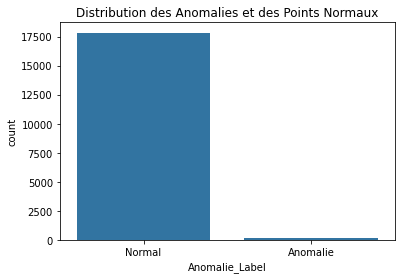

In [21]:
sns.countplot(x='Anomalie_Label', data=df)
plt.title("Distribution des Anomalies et des Points Normaux")
plt.show()

#### Some examples of easily separable data

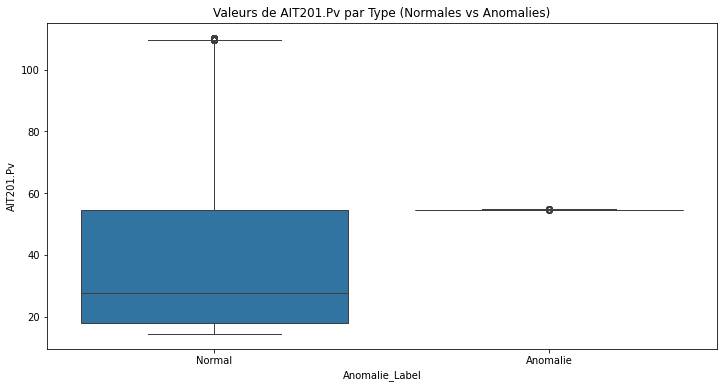

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Anomalie_Label', y='AIT201.Pv', data=df)
plt.title("Valeurs de AIT201.Pv par Type (Normales vs Anomalies)")
plt.show()

From this we can deduce that if this variable is different from 60, then it is not an anomoly

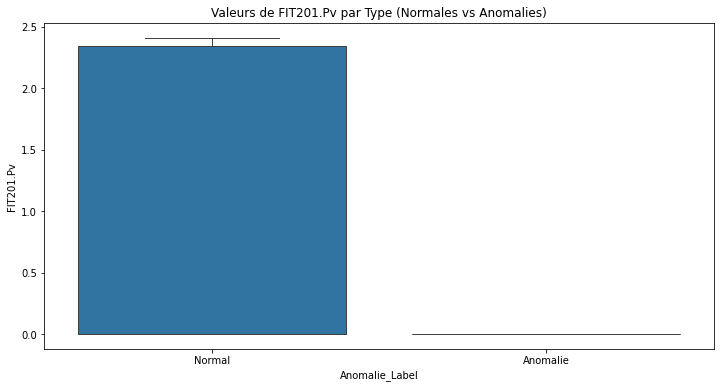

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Anomalie_Label', y='FIT201.Pv', data=df)
plt.title("Valeurs de FIT201.Pv par Type (Normales vs Anomalies)")
plt.show()

From this, we can deduce that if this variable is superior than 0, then it is not an anomaly.

In [26]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled)

df['PCA1'] = reduced_data[:, 0]
df['PCA2'] = reduced_data[:, 1]

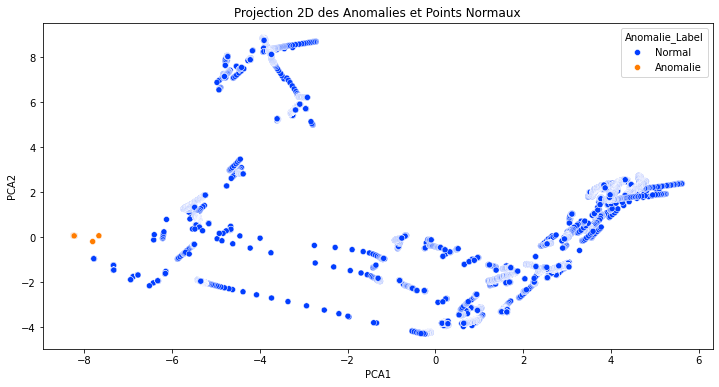

In [27]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Anomalie_Label', palette='bright', data=df)
plt.title("Projection 2D des Anomalies et Points Normaux")
plt.show()

PCA works pretty well, isolated data is easily separable

#### option 2 : Adversarial attacks against classification

In [ ]:
X = df.drop(columns=['Anomalie_Label'])
y = df['Anomalie_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print(clf.score(X_test, y_test))

0.9987037037037036


In [36]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Anomalie       0.94      0.92      0.93        50
      Normal       1.00      1.00      1.00      5350

    accuracy                           1.00      5400
   macro avg       0.97      0.96      0.96      5400
weighted avg       1.00      1.00      1.00      5400



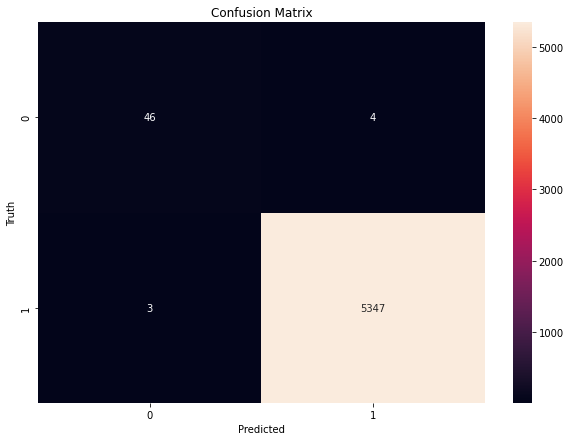

In [ ]:
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()